In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from hydra import compose, initialize
from matplotlib.image import imread
from PIL import Image
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

from sneakers_ml.data.split import create_dataframe
from sneakers_ml.features.resnet152 import ResNet152Features

warnings.filterwarnings("ignore")

with initialize(version_base=None, config_path="../../config", job_name="resnet-eda"):
    cfg = compose(config_name="config")
    features_class = ResNet152Features(cfg.features.resnet152.config, cfg.data)

# Получение эмбеддингов resnet для картинок по брендам

In [2]:
features, classes, class_to_idx = features_class._load_features(features_class.config.splits.full)

In [4]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes_idx = classes[:, 1]
images_idx = classes[:, 0]

In [5]:
def plot_dataset(dim_reduced_features):
    dataframe = create_dataframe(dim_reduced_features, classes_idx, idx_to_class, images_idx)
    sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Сжатие с помощью SVD до двух компонент

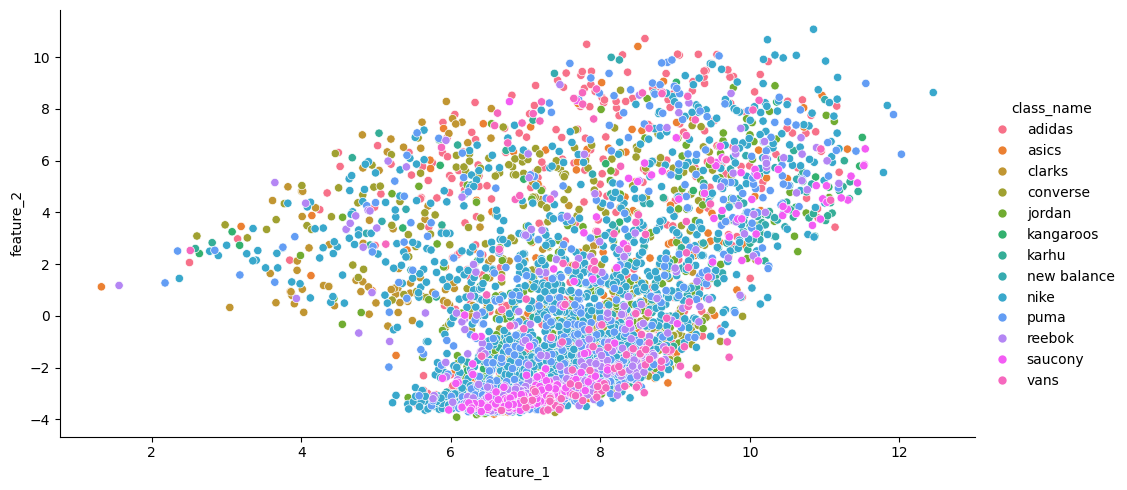

In [6]:
SVD_2 = TruncatedSVD(n_components=2, random_state=42).fit_transform(features)
plot_dataset(SVD_2)

# Сжатие с помощью PCA до двух компонент

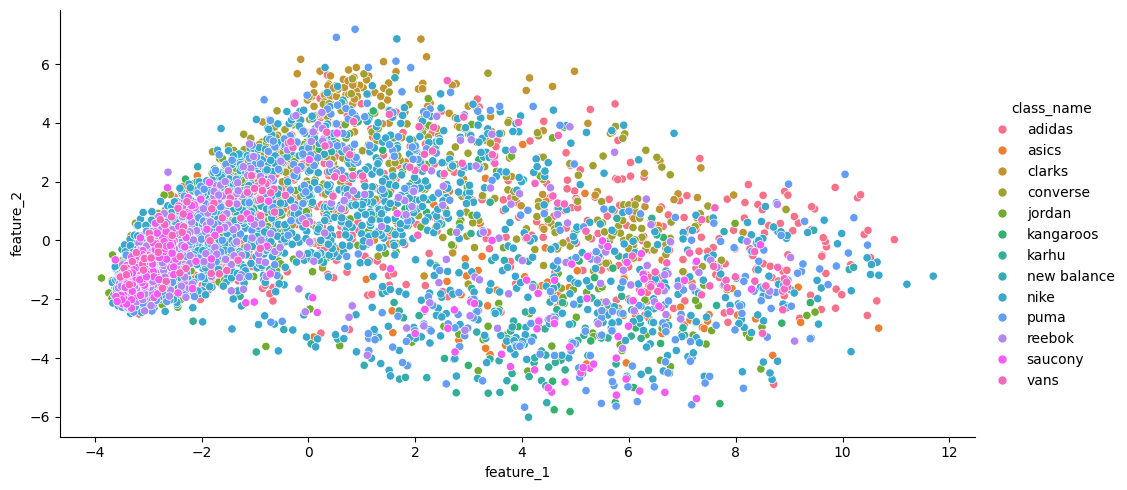

In [7]:
PCA_2 = PCA(n_components=2, random_state=42).fit_transform(features)
plot_dataset(PCA_2)

# TSNE до двух компонент (сначала сжимаем с помощью PCA до 50 компонент, потом уже TSNE до двух)

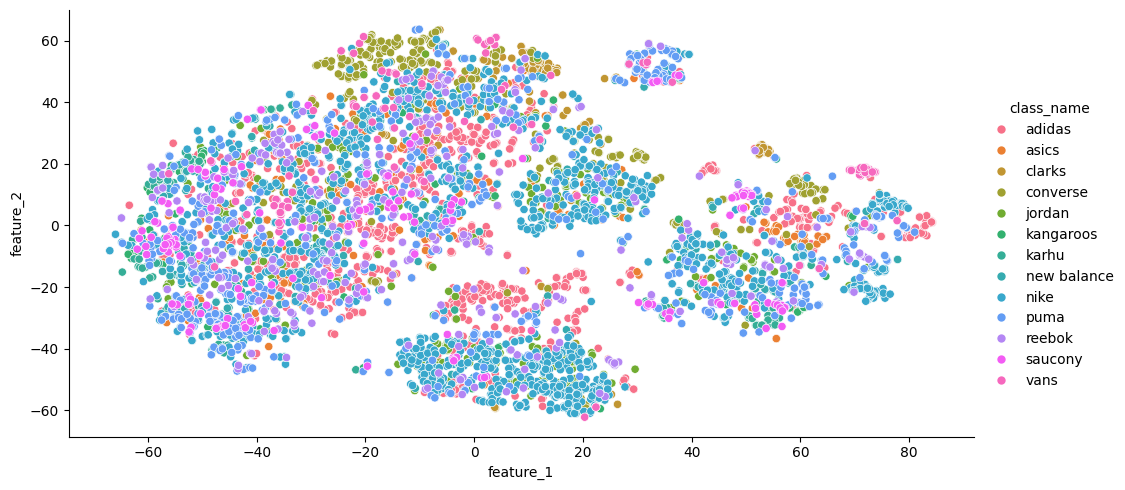

In [8]:
PCA_50 = PCA(n_components=50, random_state=42).fit_transform(features)
TSNE_2 = TSNE(n_components=2, random_state=42).fit_transform(PCA_50)
plot_dataset(TSNE_2)

# Видны кластеры, но они не соответствуют брендам - скорее всего они кучкуются по *ракурсам* изображений.

# Сделаем UMAP и посмотрим какие картинки в кластерах!!

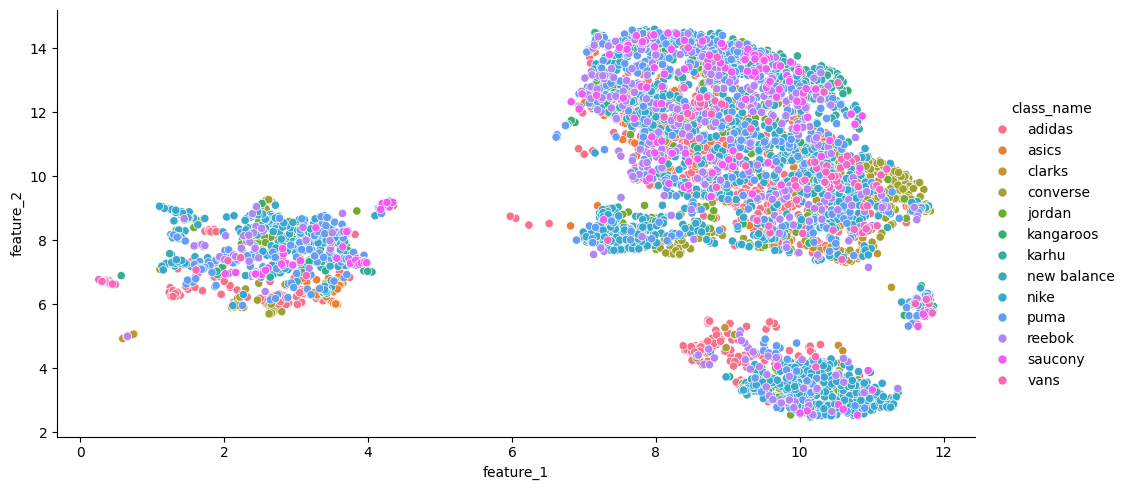

In [9]:
umap_model = UMAP(n_components=2, n_jobs=-1, random_state=42)
umap_embeddings = umap_model.fit_transform(features)
plot_dataset(umap_embeddings)

# Визуализируем самый левый пучок - там подошвы

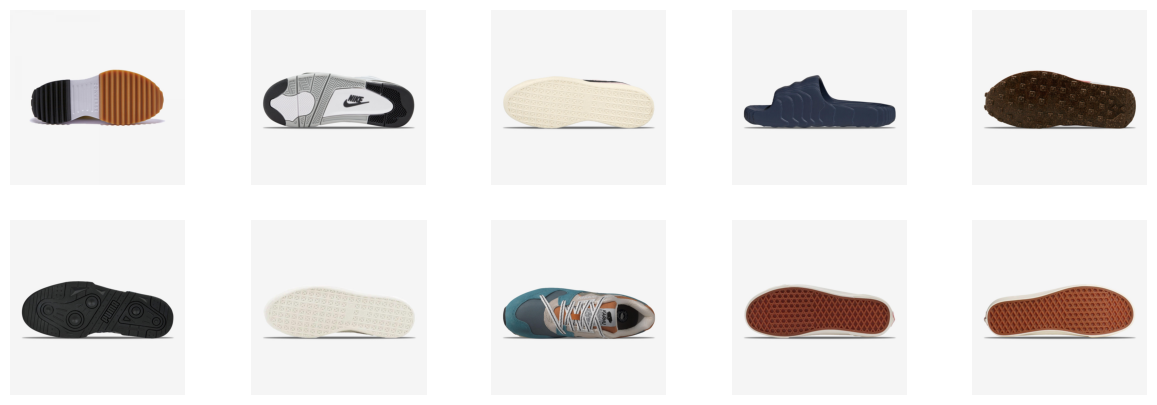

In [10]:
dataframe = create_dataframe(umap_embeddings, classes_idx, idx_to_class, images_idx)
images = dataframe[dataframe["feature_1"] <= 5.5]["image"].sample(10).to_list()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for idx, ax in enumerate(axes.flatten()):
    image = imread(images[idx])
    ax.imshow(image)
    ax.axis("off")

plt.show()

# Визуализируем правый нижний пучок

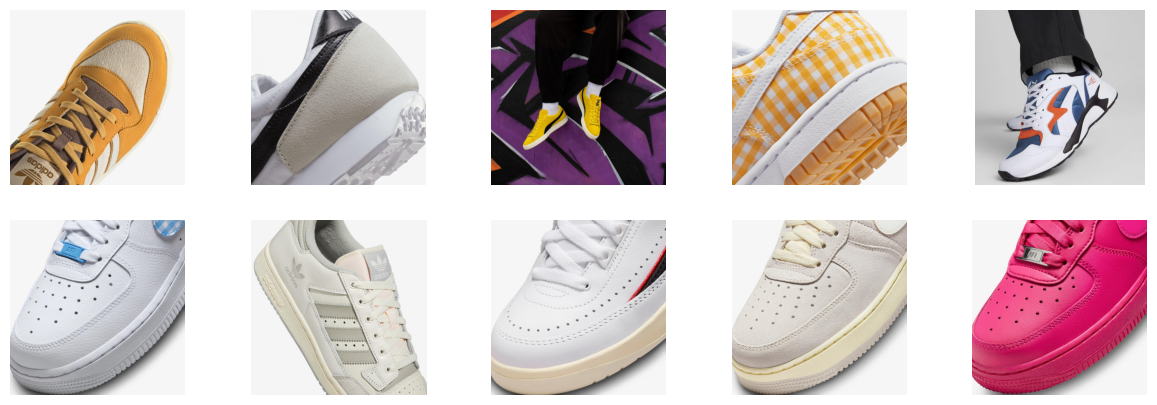

In [11]:
images = dataframe[(dataframe["feature_1"] >= 8) & (dataframe["feature_2"] <= 7)]["image"].sample(10).tolist()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for idx, ax in enumerate(axes.flatten()):
    image = imread(images[idx])
    ax.imshow(image)
    ax.axis("off")

plt.show()

# Визуализируем самый большой верхний правый кластер

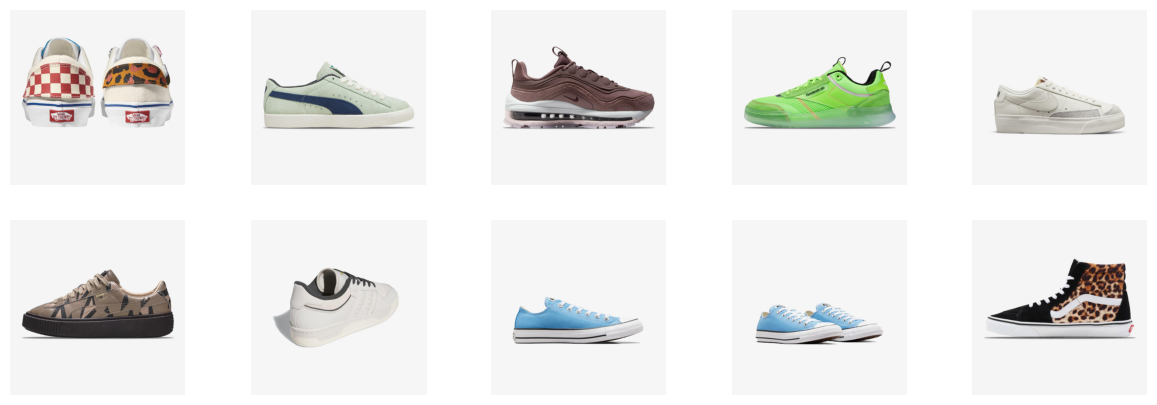

In [12]:
images = dataframe[(dataframe["feature_1"] >= 6) & (dataframe["feature_2"] >= 7.5)]["image"].sample(10).to_list()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for idx, ax in enumerate(axes.flatten()):
    image = imread(images[idx])
    ax.imshow(image)
    ax.axis("off")

plt.show()

# Посмотрим можно ли удалить дубликаты - картинки с похожими эмбеддингами

In [13]:
similarity_matrix = cosine_similarity(features)
threshold = 0.99
paths = list(classes[:, 0])

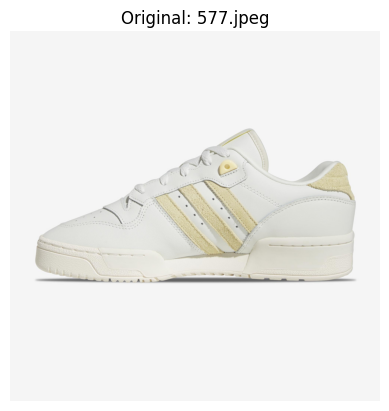

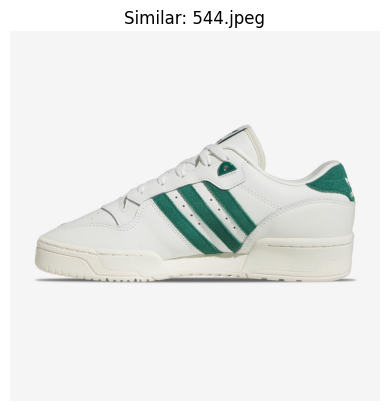

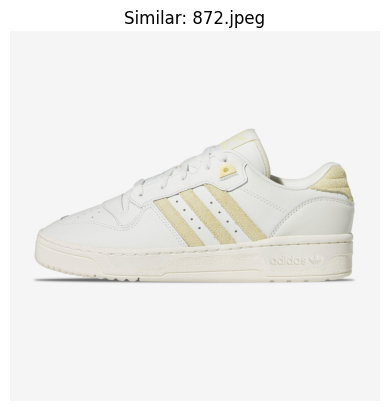

In [14]:
for i in range(len(paths)):
    similar_indices = np.where(similarity_matrix[i] > threshold)[0]

    if len(similar_indices) > 2:
        current_image_path = paths[i]
        current_image = Image.open(current_image_path)
        plt.imshow(current_image)
        plt.title(f"Original: {os.path.basename(current_image_path)}")
        plt.axis("off")
        plt.show()

        for idx in similar_indices:
            if idx != i:
                similar_image_path = paths[idx]
                similar_image = Image.open(similar_image_path)

                plt.imshow(similar_image)
                plt.title(f"Similar: {os.path.basename(similar_image_path)}")
                plt.axis("off")
                plt.show()
        break